In [1]:
import os
import cv2
import random
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image

# 학습용 데이터 만들기

In [ ]:
# 학습데이터 정제
# 임의의 프레임 추출코드 - 항목마다 전체 이미지 갯수가 다르다
base_dir = '../data/pre'
folder_list = os.listdir(base_dir)

batch_size = 1
batch_x_data = list()
batch_t_data = list()

frame_num = 20

for folder in folder_list[0:1*batch_size]:
    for n in range(10):
        file_list = os.listdir(os.path.join(base_dir, (folder+'/'+str(n))))
        temp_data = list()
        for i in range(frame_num):
            img = Image.open(os.path.join(base_dir, (folder+'/'+str(n)+'/'+str(int(i*(len(file_list)/frame_num)))+'.jpg')))
            img = img.resize(size=(112, 112))
            img = np.array(img)
            img = img.reshape(112,112,3)
            temp_data.append(img)
        temp_data = np.array(temp_data)
        batch_x_data.append(temp_data)
        batch_t_data.append(n)

In [ ]:
# 리스트인 batch_x_data를 ndarray로
batch_x_data = np.array(batch_x_data)
print(batch_x_data.shape)

In [ ]:
# 축변경
batch_x_data = np.swapaxes(batch_x_data,1,2)
batch_x_data = np.swapaxes(batch_x_data,2,3)

print(batch_x_data.shape)

In [ ]:
# one_hot_encording
batch_t_data = np.array(batch_t_data)
batch_t_data = pd.DataFrame(batch_t_data, columns=['t'])
display(batch_t_data)
batch_t_data = pd.get_dummies(batch_t_data['t'])
display(batch_t_data)

In [ ]:
# 데이터 확인
figure = plt.figure(figsize=(10,10))

fig_list=list()
for i in range(20):
    fig_list.append(figure.add_subplot(5,4,i+1))
    test = batch_x_data[0,:,:,i,:]
    fig_list[i].imshow(test.reshape(112,112,3))

# 모델

In [2]:
# GPU 메모리제한
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # 텐서플로가 첫 번째 GPU에 1GB 메모리만 할당하도록 제한
  try:
    tf.config.experimental.set_virtual_device_configuration(
        gpus[0],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024*6)])
  except RuntimeError as e:
    # 프로그램 시작시에 가상 장치가 설정되어야만 합니다
    print(e)

In [3]:
# 모델 작성
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Conv3D, MaxPool3D,Flatten, Activation, BatchNormalization
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.regularizers import l2

weight_decay = 0.005
frame_num = 20
num_class = 10

model = Sequential()
model.add(Conv3D(64,(3,3,3), strides=(1,1,1), padding='same',
                 activation='relu', kernel_regularizer=l2(weight_decay),
                 input_shape=(112,112,frame_num,1)))
model.add(MaxPool3D((2,2,1),strides=(2,2,1),padding='same'))

model.add(Conv3D(128,(3,3,3), strides=(1,1,1), padding='same',
                 activation='relu', kernel_regularizer=l2(weight_decay)))
model.add(MaxPool3D((2,2,2),strides=(2,2,2),padding='same'))

model.add(Conv3D(256,(3,3,3), strides=(1,1,1), padding='same',
                 activation='relu', kernel_regularizer=l2(weight_decay)))
model.add(Conv3D(256,(3,3,3), strides=(1,1,1), padding='same',
                 activation='relu', kernel_regularizer=l2(weight_decay)))
model.add(MaxPool3D((2,2,2),strides=(2,2,2),padding='same'))

model.add(Conv3D(512,(3,3,3), strides=(1,1,1), padding='same',
                 activation='relu', kernel_regularizer=l2(weight_decay)))
model.add(Conv3D(512,(3,3,3), strides=(1,1,1), padding='same',
                 activation='relu', kernel_regularizer=l2(weight_decay)))
model.add(MaxPool3D((2,2,2),strides=(2,2,2),padding='same'))

model.add(Conv3D(512,(3,3,3), strides=(1,1,1), padding='same',
                 activation='relu', kernel_regularizer=l2(weight_decay)))
model.add(Conv3D(512,(3,3,3), strides=(1,1,1), padding='same',
                 activation='relu', kernel_regularizer=l2(weight_decay)))
model.add(MaxPool3D((2,2,2),strides=(2,2,2),padding='same'))

model.add(Flatten())
model.add(Dense(units=int(4096), activation='relu'))
model.add(Dense(units=int(4096), activation='relu'))

model.add(Dense(num_class, activation='softmax'))
model.summary()

model.compile(optimizer=RMSprop(learning_rate=1e-4), loss='categorical_crossentropy',metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 112, 112, 20, 64)  1792      
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 56, 56, 20, 64)    0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 56, 56, 20, 128)   221312    
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 28, 28, 10, 128)   0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 28, 28, 10, 256)   884992    
_________________________________________________________________
conv3d_3 (Conv3D)            (None, 28, 28, 10, 256)   1769728   
_________________________________________________________________
max_pooling3d_2 (MaxPooling3 (None, 14, 14, 5, 256)    0

In [4]:
# 학습데이터 정제
# 임의의 프레임 추출코드 - 항목마다 전체 이미지 갯수가 다르다
base_dir = '../data/pre'
folder_list = os.listdir(base_dir)

batch_size = 1
shuffle_list = list(range(0,num_class))*batch_size

for batch in range(int(42-batch_size/batch_size)):
    batch_x_data = list()
    batch_t_data = list()
    for folder in folder_list[batch*batch_size:(batch+1)*batch_size]:
        for n in range(num_class):
            file_list = os.listdir(os.path.join(base_dir, (folder+'/'+str(n))))
            temp_data = list()
            for i in range(frame_num):
                img = Image.open(os.path.join(base_dir, (folder+'/'+str(n)+'/'+str(int(i*(len(file_list)/frame_num)))+'.jpg')))
                img = img.resize(size=(112, 112))
                img = np.array(img)
                # 흑백 이미지 전용 코드
                img = img.reshape(112, 112, 1)
                temp_data.append(img)
            temp_data = np.array(temp_data)
            batch_x_data.append(temp_data)
            batch_t_data.append(n)

    # 리스트인 batch_x_data를 ndarray로
    batch_x_data = np.array(batch_x_data)
    batch_t_data = np.array(batch_t_data)
    
    # 축변경
    batch_x_data = np.swapaxes(batch_x_data,1,2)
    batch_x_data = np.swapaxes(batch_x_data,2,3)
    
    # data shuffle
    random.shuffle(shuffle_list)
    
    batch_x_data = batch_x_data[shuffle_list]
    batch_t_data = batch_t_data[shuffle_list]

    # one_hot_encording
    batch_t_data = np.array(batch_t_data)
    batch_t_data = pd.DataFrame(batch_t_data, columns=['t'])
    batch_t_data = pd.get_dummies(batch_t_data['t'])
    
    # learning
    history = model.fit(x=batch_x_data, y=batch_t_data, epochs=20, verbose=1, validation_split=0.2)

Epoch 1/20
1/1 [==============================] - 1s 512ms/step - loss: 14.4049 - accuracy: 0.1250 - val_loss: 376.8446 - val_accuracy: 0.0000e+00
Epoch 2/20
1/1 [==============================] - 1s 585ms/step - loss: 116.9015 - accuracy: 0.1250 - val_loss: 17.3420 - val_accuracy: 0.0000e+00
Epoch 3/20
1/1 [==============================] - 1s 583ms/step - loss: 14.6370 - accuracy: 0.1250 - val_loss: 14.6016 - val_accuracy: 0.0000e+00
Epoch 4/20
1/1 [==============================] - 1s 580ms/step - loss: 13.9342 - accuracy: 0.1250 - val_loss: 15.0724 - val_accuracy: 0.0000e+00
Epoch 5/20
1/1 [==============================] - 1s 583ms/step - loss: 13.7913 - accuracy: 0.3750 - val_loss: 15.9369 - val_accuracy: 0.0000e+00
Epoch 6/20
1/1 [==============================] - 1s 580ms/step - loss: 13.6645 - accuracy: 0.3750 - val_loss: 17.4955 - val_accuracy: 0.0000e+00
Epoch 7/20
1/1 [==============================] - 1s 583ms/step - loss: 13.5933 - accuracy: 0.1250 - val_loss: 16.5139 - v

Epoch 17/20
1/1 [==============================] - 1s 626ms/step - loss: 11.6364 - accuracy: 0.1250 - val_loss: 13.0844 - val_accuracy: 0.0000e+00
Epoch 18/20
1/1 [==============================] - 1s 691ms/step - loss: 11.5524 - accuracy: 0.2500 - val_loss: 13.7823 - val_accuracy: 0.0000e+00
Epoch 19/20
1/1 [==============================] - 1s 646ms/step - loss: 11.4703 - accuracy: 0.2500 - val_loss: 13.9482 - val_accuracy: 0.0000e+00
Epoch 20/20
1/1 [==============================] - 1s 662ms/step - loss: 11.3952 - accuracy: 0.3750 - val_loss: 15.3833 - val_accuracy: 0.0000e+00
Epoch 1/20
1/1 [==============================] - 1s 677ms/step - loss: 11.7972 - accuracy: 0.1250 - val_loss: 11.7493 - val_accuracy: 0.0000e+00
Epoch 2/20
1/1 [==============================] - 1s 629ms/step - loss: 11.5350 - accuracy: 0.1250 - val_loss: 11.8508 - val_accuracy: 0.0000e+00
Epoch 3/20
1/1 [==============================] - 1s 643ms/step - loss: 11.4647 - accuracy: 0.1250 - val_loss: 12.0234 -

1/1 [==============================] - 1s 636ms/step - loss: 9.5386 - accuracy: 0.1250 - val_loss: 9.1809 - val_accuracy: 0.0000e+00
Epoch 14/20
1/1 [==============================] - 1s 638ms/step - loss: 8.6912 - accuracy: 0.1250 - val_loss: 10.5236 - val_accuracy: 0.0000e+00
Epoch 15/20
1/1 [==============================] - 1s 629ms/step - loss: 8.6109 - accuracy: 0.1250 - val_loss: 9.0276 - val_accuracy: 0.0000e+00
Epoch 16/20
1/1 [==============================] - 1s 655ms/step - loss: 8.5817 - accuracy: 0.1250 - val_loss: 9.6565 - val_accuracy: 0.0000e+00
Epoch 17/20
1/1 [==============================] - 1s 696ms/step - loss: 8.4548 - accuracy: 0.3750 - val_loss: 11.5992 - val_accuracy: 0.0000e+00
Epoch 18/20
1/1 [==============================] - 1s 804ms/step - loss: 8.3550 - accuracy: 0.1250 - val_loss: 9.8688 - val_accuracy: 0.0000e+00
Epoch 19/20
1/1 [==============================] - 1s 669ms/step - loss: 8.3070 - accuracy: 0.1250 - val_loss: 13.7108 - val_accuracy: 0.000

1/1 [==============================] - 1s 777ms/step - loss: 5.9018 - accuracy: 0.1250 - val_loss: 9.2701 - val_accuracy: 0.0000e+00
Epoch 10/20
1/1 [==============================] - 1s 990ms/step - loss: 5.8557 - accuracy: 0.2500 - val_loss: 6.1891 - val_accuracy: 0.0000e+00
Epoch 11/20
1/1 [==============================] - 1s 792ms/step - loss: 5.8900 - accuracy: 0.1250 - val_loss: 6.7132 - val_accuracy: 0.0000e+00
Epoch 12/20
1/1 [==============================] - 1s 706ms/step - loss: 5.7728 - accuracy: 0.1250 - val_loss: 6.6249 - val_accuracy: 0.0000e+00
Epoch 13/20
1/1 [==============================] - 1s 742ms/step - loss: 5.6568 - accuracy: 0.1250 - val_loss: 12.5963 - val_accuracy: 0.0000e+00
Epoch 14/20
1/1 [==============================] - 1s 793ms/step - loss: 6.4629 - accuracy: 0.1250 - val_loss: 5.9513 - val_accuracy: 0.0000e+00
Epoch 15/20
1/1 [==============================] - 1s 887ms/step - loss: 5.7883 - accuracy: 0.1250 - val_loss: 5.9894 - val_accuracy: 0.0000e

Epoch 6/20
1/1 [==============================] - 1s 623ms/step - loss: 4.0809 - accuracy: 0.1250 - val_loss: 5.7405 - val_accuracy: 0.0000e+00
Epoch 7/20
1/1 [==============================] - 1s 626ms/step - loss: 4.0148 - accuracy: 0.1250 - val_loss: 5.4895 - val_accuracy: 0.0000e+00
Epoch 8/20
1/1 [==============================] - 1s 628ms/step - loss: 3.9256 - accuracy: 0.1250 - val_loss: 11.8239 - val_accuracy: 0.0000e+00
Epoch 9/20
1/1 [==============================] - 1s 629ms/step - loss: 4.3716 - accuracy: 0.1250 - val_loss: 4.5447 - val_accuracy: 0.0000e+00
Epoch 10/20
1/1 [==============================] - 1s 630ms/step - loss: 4.0063 - accuracy: 0.1250 - val_loss: 4.6926 - val_accuracy: 0.0000e+00
Epoch 11/20
1/1 [==============================] - 1s 624ms/step - loss: 3.9562 - accuracy: 0.1250 - val_loss: 5.0066 - val_accuracy: 0.0000e+00
Epoch 12/20
1/1 [==============================] - 1s 626ms/step - loss: 3.8980 - accuracy: 0.1250 - val_loss: 7.0938 - val_accuracy:

Epoch 3/20
1/1 [==============================] - 1s 834ms/step - loss: 3.1618 - accuracy: 0.1250 - val_loss: 3.2863 - val_accuracy: 0.0000e+00
Epoch 4/20
1/1 [==============================] - 1s 669ms/step - loss: 3.1076 - accuracy: 0.1250 - val_loss: 6.7944 - val_accuracy: 0.0000e+00
Epoch 5/20
1/1 [==============================] - 1s 664ms/step - loss: 3.2315 - accuracy: 0.1250 - val_loss: 3.2167 - val_accuracy: 0.0000e+00
Epoch 6/20
1/1 [==============================] - 1s 729ms/step - loss: 3.1019 - accuracy: 0.1250 - val_loss: 3.2973 - val_accuracy: 0.0000e+00
Epoch 7/20
1/1 [==============================] - 1s 874ms/step - loss: 3.0675 - accuracy: 0.1250 - val_loss: 3.4058 - val_accuracy: 0.0000e+00
Epoch 8/20
1/1 [==============================] - 1s 643ms/step - loss: 3.0371 - accuracy: 0.1250 - val_loss: 3.9012 - val_accuracy: 0.0000e+00
Epoch 9/20
1/1 [==============================] - 1s 897ms/step - loss: 2.9738 - accuracy: 0.1250 - val_loss: 9.1246 - val_accuracy: 0.0

Epoch 20/20
1/1 [==============================] - 1s 745ms/step - loss: 2.5650 - accuracy: 0.1250 - val_loss: 5.1599 - val_accuracy: 0.0000e+00
Epoch 1/20
1/1 [==============================] - 1s 719ms/step - loss: 3.1752 - accuracy: 0.1250 - val_loss: 2.6755 - val_accuracy: 0.0000e+00
Epoch 2/20
1/1 [==============================] - 1s 657ms/step - loss: 2.7830 - accuracy: 0.1250 - val_loss: 2.7192 - val_accuracy: 0.0000e+00
Epoch 3/20
1/1 [==============================] - 1s 620ms/step - loss: 2.7544 - accuracy: 0.1250 - val_loss: 2.7465 - val_accuracy: 0.0000e+00
Epoch 4/20
1/1 [==============================] - 1s 622ms/step - loss: 2.7341 - accuracy: 0.1250 - val_loss: 2.7681 - val_accuracy: 0.0000e+00
Epoch 5/20
1/1 [==============================] - 1s 623ms/step - loss: 2.7176 - accuracy: 0.1250 - val_loss: 2.7910 - val_accuracy: 0.0000e+00
Epoch 6/20
1/1 [==============================] - 1s 626ms/step - loss: 2.7029 - accuracy: 0.1250 - val_loss: 2.8184 - val_accuracy: 0.

Epoch 17/20
1/1 [==============================] - 1s 623ms/step - loss: 2.3131 - accuracy: 0.1250 - val_loss: 3.7249 - val_accuracy: 0.0000e+00
Epoch 18/20
1/1 [==============================] - 1s 824ms/step - loss: 2.2736 - accuracy: 0.2500 - val_loss: 4.1834 - val_accuracy: 0.0000e+00
Epoch 19/20
1/1 [==============================] - 1s 698ms/step - loss: 2.0872 - accuracy: 0.2500 - val_loss: 4.7514 - val_accuracy: 0.0000e+00
Epoch 20/20
1/1 [==============================] - 1s 641ms/step - loss: 2.0212 - accuracy: 0.2500 - val_loss: 5.6874 - val_accuracy: 0.0000e+00
Epoch 1/20
1/1 [==============================] - 1s 644ms/step - loss: 3.1236 - accuracy: 0.1250 - val_loss: 2.6526 - val_accuracy: 0.0000e+00
Epoch 2/20
1/1 [==============================] - 1s 634ms/step - loss: 2.6378 - accuracy: 0.1250 - val_loss: 2.5541 - val_accuracy: 0.0000e+00
Epoch 3/20
1/1 [==============================] - 1s 798ms/step - loss: 2.5930 - accuracy: 0.1250 - val_loss: 2.6968 - val_accuracy:

Epoch 14/20
1/1 [==============================] - 1s 622ms/step - loss: 2.5474 - accuracy: 0.2500 - val_loss: 3.0944 - val_accuracy: 0.0000e+00
Epoch 15/20
1/1 [==============================] - 1s 622ms/step - loss: 2.0589 - accuracy: 0.2500 - val_loss: 3.2984 - val_accuracy: 0.0000e+00
Epoch 16/20
1/1 [==============================] - 1s 620ms/step - loss: 2.0172 - accuracy: 0.2500 - val_loss: 3.4562 - val_accuracy: 0.0000e+00
Epoch 17/20
1/1 [==============================] - 1s 622ms/step - loss: 1.9965 - accuracy: 0.2500 - val_loss: 3.7510 - val_accuracy: 0.0000e+00
Epoch 18/20
1/1 [==============================] - 1s 625ms/step - loss: 1.9683 - accuracy: 0.2500 - val_loss: 6.1733 - val_accuracy: 0.0000e+00
Epoch 19/20
1/1 [==============================] - 1s 623ms/step - loss: 1.9272 - accuracy: 0.2500 - val_loss: 3.8833 - val_accuracy: 0.0000e+00
Epoch 20/20
1/1 [==============================] - 1s 624ms/step - loss: 1.9526 - accuracy: 0.2500 - val_loss: 4.5991 - val_accura

1/1 [==============================] - 1s 747ms/step - loss: 2.3386 - accuracy: 0.1250 - val_loss: 3.0480 - val_accuracy: 0.0000e+00
Epoch 11/20
1/1 [==============================] - 1s 790ms/step - loss: 2.3547 - accuracy: 0.1250 - val_loss: 3.9180 - val_accuracy: 0.0000e+00
Epoch 12/20
1/1 [==============================] - 1s 778ms/step - loss: 2.3079 - accuracy: 0.1250 - val_loss: 3.9429 - val_accuracy: 0.0000e+00
Epoch 13/20
1/1 [==============================] - 1s 750ms/step - loss: 2.2867 - accuracy: 0.1250 - val_loss: 4.5613 - val_accuracy: 0.0000e+00
Epoch 14/20
1/1 [==============================] - 1s 629ms/step - loss: 2.2630 - accuracy: 0.1250 - val_loss: 5.2647 - val_accuracy: 0.0000e+00
Epoch 15/20
1/1 [==============================] - 1s 630ms/step - loss: 2.2366 - accuracy: 0.1250 - val_loss: 6.6453 - val_accuracy: 0.0000e+00
Epoch 16/20
1/1 [==============================] - 1s 642ms/step - loss: 2.2312 - accuracy: 0.1250 - val_loss: 5.6176 - val_accuracy: 0.0000e+

Epoch 7/20
1/1 [==============================] - 1s 632ms/step - loss: 2.2913 - accuracy: 0.1250 - val_loss: 3.6831 - val_accuracy: 0.0000e+00
Epoch 8/20
1/1 [==============================] - 1s 627ms/step - loss: 2.2765 - accuracy: 0.1250 - val_loss: 3.8720 - val_accuracy: 0.0000e+00
Epoch 9/20
1/1 [==============================] - 1s 625ms/step - loss: 2.2596 - accuracy: 0.1250 - val_loss: 4.1367 - val_accuracy: 0.0000e+00
Epoch 10/20
1/1 [==============================] - 1s 622ms/step - loss: 2.2402 - accuracy: 0.1250 - val_loss: 4.5547 - val_accuracy: 0.0000e+00
Epoch 11/20
1/1 [==============================] - 1s 624ms/step - loss: 2.2185 - accuracy: 0.1250 - val_loss: 5.3253 - val_accuracy: 0.0000e+00
Epoch 12/20
1/1 [==============================] - 1s 625ms/step - loss: 2.1974 - accuracy: 0.1250 - val_loss: 6.9505 - val_accuracy: 0.0000e+00
Epoch 13/20
1/1 [==============================] - 1s 623ms/step - loss: 2.1838 - accuracy: 0.1250 - val_loss: 9.7093 - val_accuracy:

1/1 [==============================] - 1s 627ms/step - loss: 2.3328 - accuracy: 0.1250 - val_loss: 2.9105 - val_accuracy: 0.0000e+00
Epoch 4/20
1/1 [==============================] - 1s 640ms/step - loss: 2.3101 - accuracy: 0.1250 - val_loss: 3.0654 - val_accuracy: 0.0000e+00
Epoch 5/20
1/1 [==============================] - 1s 629ms/step - loss: 2.2906 - accuracy: 0.1250 - val_loss: 3.2766 - val_accuracy: 0.0000e+00
Epoch 6/20
1/1 [==============================] - 1s 629ms/step - loss: 2.2675 - accuracy: 0.1250 - val_loss: 3.6411 - val_accuracy: 0.0000e+00
Epoch 7/20
1/1 [==============================] - 1s 629ms/step - loss: 2.2387 - accuracy: 0.1250 - val_loss: 4.7005 - val_accuracy: 0.0000e+00
Epoch 8/20
1/1 [==============================] - 1s 626ms/step - loss: 2.1960 - accuracy: 0.1250 - val_loss: 9.2409 - val_accuracy: 0.0000e+00
Epoch 9/20
1/1 [==============================] - 1s 625ms/step - loss: 2.1684 - accuracy: 0.1250 - val_loss: 5.9919 - val_accuracy: 0.0000e+00
Epo

Epoch 20/20
1/1 [==============================] - 1s 625ms/step - loss: 2.1440 - accuracy: 0.1250 - val_loss: 6.2532 - val_accuracy: 0.0000e+00
Epoch 1/20
1/1 [==============================] - 1s 645ms/step - loss: 3.2617 - accuracy: 0.1250 - val_loss: 2.3881 - val_accuracy: 0.0000e+00
Epoch 2/20
1/1 [==============================] - 1s 630ms/step - loss: 2.3882 - accuracy: 0.1250 - val_loss: 2.4342 - val_accuracy: 0.0000e+00
Epoch 3/20
1/1 [==============================] - 1s 625ms/step - loss: 2.3713 - accuracy: 0.1250 - val_loss: 2.4860 - val_accuracy: 0.0000e+00
Epoch 4/20
1/1 [==============================] - 1s 629ms/step - loss: 2.3558 - accuracy: 0.1250 - val_loss: 2.5596 - val_accuracy: 0.0000e+00
Epoch 5/20
1/1 [==============================] - 1s 660ms/step - loss: 2.3373 - accuracy: 0.1250 - val_loss: 2.6878 - val_accuracy: 0.0000e+00
Epoch 6/20
1/1 [==============================] - 1s 817ms/step - loss: 2.3101 - accuracy: 0.1250 - val_loss: 2.9646 - val_accuracy: 0.

Epoch 17/20
1/1 [==============================] - 1s 622ms/step - loss: 2.1264 - accuracy: 0.1250 - val_loss: 7.4714 - val_accuracy: 0.0000e+00
Epoch 18/20
1/1 [==============================] - 1s 621ms/step - loss: 2.1204 - accuracy: 0.1250 - val_loss: 8.8766 - val_accuracy: 0.0000e+00
Epoch 19/20
1/1 [==============================] - 1s 625ms/step - loss: 2.1729 - accuracy: 0.1250 - val_loss: 4.9332 - val_accuracy: 0.0000e+00
Epoch 20/20
1/1 [==============================] - 1s 618ms/step - loss: 2.1961 - accuracy: 0.1250 - val_loss: 4.3602 - val_accuracy: 0.0000e+00
Epoch 1/20
1/1 [==============================] - 1s 640ms/step - loss: 2.7151 - accuracy: 0.1250 - val_loss: 2.3098 - val_accuracy: 0.0000e+00
Epoch 2/20
1/1 [==============================] - 1s 625ms/step - loss: 2.4256 - accuracy: 0.1250 - val_loss: 2.5685 - val_accuracy: 0.0000e+00
Epoch 3/20
1/1 [==============================] - 1s 625ms/step - loss: 2.3223 - accuracy: 0.1250 - val_loss: 3.0662 - val_accuracy:

Epoch 14/20
1/1 [==============================] - 1s 712ms/step - loss: 2.2373 - accuracy: 0.1250 - val_loss: 3.1736 - val_accuracy: 0.0000e+00
Epoch 15/20
1/1 [==============================] - 1s 756ms/step - loss: 2.2067 - accuracy: 0.1250 - val_loss: 4.0550 - val_accuracy: 0.0000e+00
Epoch 16/20
1/1 [==============================] - 1s 679ms/step - loss: 2.1545 - accuracy: 0.1250 - val_loss: 8.4991 - val_accuracy: 0.0000e+00
Epoch 17/20
1/1 [==============================] - 1s 713ms/step - loss: 2.1224 - accuracy: 0.1250 - val_loss: 5.8082 - val_accuracy: 0.0000e+00
Epoch 18/20
1/1 [==============================] - 1s 649ms/step - loss: 2.1552 - accuracy: 0.1250 - val_loss: 3.6545 - val_accuracy: 0.0000e+00
Epoch 19/20
1/1 [==============================] - 1s 639ms/step - loss: 2.1662 - accuracy: 0.1250 - val_loss: 5.2581 - val_accuracy: 0.0000e+00
Epoch 20/20
1/1 [==============================] - 1s 641ms/step - loss: 2.1260 - accuracy: 0.1250 - val_loss: 6.7006 - val_accura

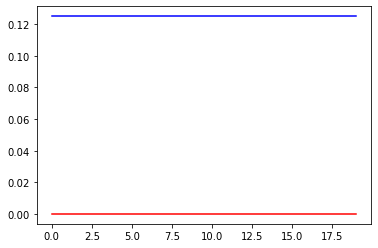

In [5]:
plt.plot(history.history['accuracy'], 'b')
plt.plot(history.history['val_accuracy'], 'r')
plt.show()

In [6]:
batch_x_data = list()
batch_t_data = list()
for folder in folder_list[42-batch_size:42]:
    for n in range(num_class):
        file_list = os.listdir(os.path.join(base_dir, (folder+'/'+str(n))))
        temp_data = list()
        for i in range(frame_num):
            img = Image.open(os.path.join(base_dir, (folder+'/'+str(n)+'/'+str(int(i*(len(file_list)/frame_num)))+'.jpg')))
            img = img.resize(size=(112, 112))
            img = np.array(img)
            # 흑백 이미지 전용 코드
            img = img.reshape(112, 112, 1)
            temp_data.append(img)
        temp_data = np.array(temp_data)
        batch_x_data.append(temp_data)
        batch_t_data.append(n)

# 리스트인 batch_x_data를 ndarray로
batch_x_data = np.array(batch_x_data)
batch_t_data = np.array(batch_t_data)

# 축변경
batch_x_data = np.swapaxes(batch_x_data,1,2)
batch_x_data = np.swapaxes(batch_x_data,2,3)

# data shuffle
random.shuffle(shuffle_list)

batch_x_data = batch_x_data[shuffle_list]
batch_t_data = batch_t_data[shuffle_list]

# one_hot_encording
batch_t_data = np.array(batch_t_data)
batch_t_data = pd.DataFrame(batch_t_data, columns=['t'])
batch_t_data = pd.get_dummies(batch_t_data['t'])

In [7]:
result = model.evaluate(x=batch_x_data, y=batch_t_data)
print(result)

1/1 [==============================] - 0s 977us/step - loss: 2.6222 - accuracy: 0.1000
[2.6221883296966553, 0.10000000149011612]
